# Urban Flood Forecasting - Part 3: Spatial & Network Topology Analysis

**Objective:** Understand spatial layout, network connectivity, and coupling between 1D and 2D domains.

## Tasks:
1. **Spatial Visualization** - Map node locations and elevation
2. **1D Network Analysis** - Analyze drainage network topology
3. **2D Mesh Analysis** - Analyze surface mesh connectivity
4. **Coupling Analysis** - Understand 1D-2D connections
5. **Distance Analysis** - Measure proximity between domains

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import networkx as nx
from scipy.spatial import distance_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"NetworkX version: {nx.__version__}")

Libraries imported successfully!
NetworkX version: 3.5


## 2. Setup Paths and Load Data

In [2]:
# Base directory
BASE_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models")
OUTPUT_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs")
FIGURES_DIR = OUTPUT_DIR / "figures"

MODEL_1_DIR = BASE_DIR / "Model_1"
MODEL_2_DIR = BASE_DIR / "Model_2"

print(f"✓ Directories configured")
print(f"  Base: {BASE_DIR}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Figures: {FIGURES_DIR}")

✓ Directories configured
  Base: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models
  Output: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs
  Figures: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures


In [3]:
print("=" * 80)
print("LOADING SPATIAL AND NETWORK DATA - MODEL 1")
print("=" * 80)

# Load static node data
nodes_1d = pd.read_csv(MODEL_1_DIR / "train" / "1d_nodes_static.csv")
nodes_2d = pd.read_csv(MODEL_1_DIR / "train" / "2d_nodes_static.csv")

# Load edge indices (connectivity)
edge_index_1d = pd.read_csv(MODEL_1_DIR / "train" / "1d_edge_index.csv")
edge_index_2d = pd.read_csv(MODEL_1_DIR / "train" / "2d_edge_index.csv")

# Load 1D-2D coupling
connections_1d2d = pd.read_csv(MODEL_1_DIR / "train" / "1d2d_connections.csv")

print(f"\n✓ Data loaded successfully!")
print(f"  1D Nodes: {len(nodes_1d)}")
print(f"  2D Nodes: {len(nodes_2d)}")
print(f"  1D Edges: {len(edge_index_1d)}")
print(f"  2D Edges: {len(edge_index_2d)}")
print(f"  1D-2D Connections: {len(connections_1d2d)}")

print(f"\n1D Node columns: {list(nodes_1d.columns)}")
print(f"2D Node columns: {list(nodes_2d.columns)}")
print(f"1D Edge Index columns: {list(edge_index_1d.columns)}")
print(f"1D-2D Connection columns: {list(connections_1d2d.columns)}")

LOADING SPATIAL AND NETWORK DATA - MODEL 1

✓ Data loaded successfully!
  1D Nodes: 17
  2D Nodes: 3716
  1D Edges: 16
  2D Edges: 7935
  1D-2D Connections: 16

1D Node columns: ['node_idx', 'position_x', 'position_y', 'depth', 'invert_elevation', 'surface_elevation', 'base_area']
2D Node columns: ['node_idx', 'position_x', 'position_y', 'area', 'roughness', 'min_elevation', 'elevation', 'aspect', 'curvature', 'flow_accumulation']
1D Edge Index columns: ['edge_idx', 'from_node', 'to_node']
1D-2D Connection columns: ['connection_idx', 'node_1d', 'node_2d']


## 3. Spatial Visualization - Node Locations

SPATIAL LAYOUT - ALL NODES


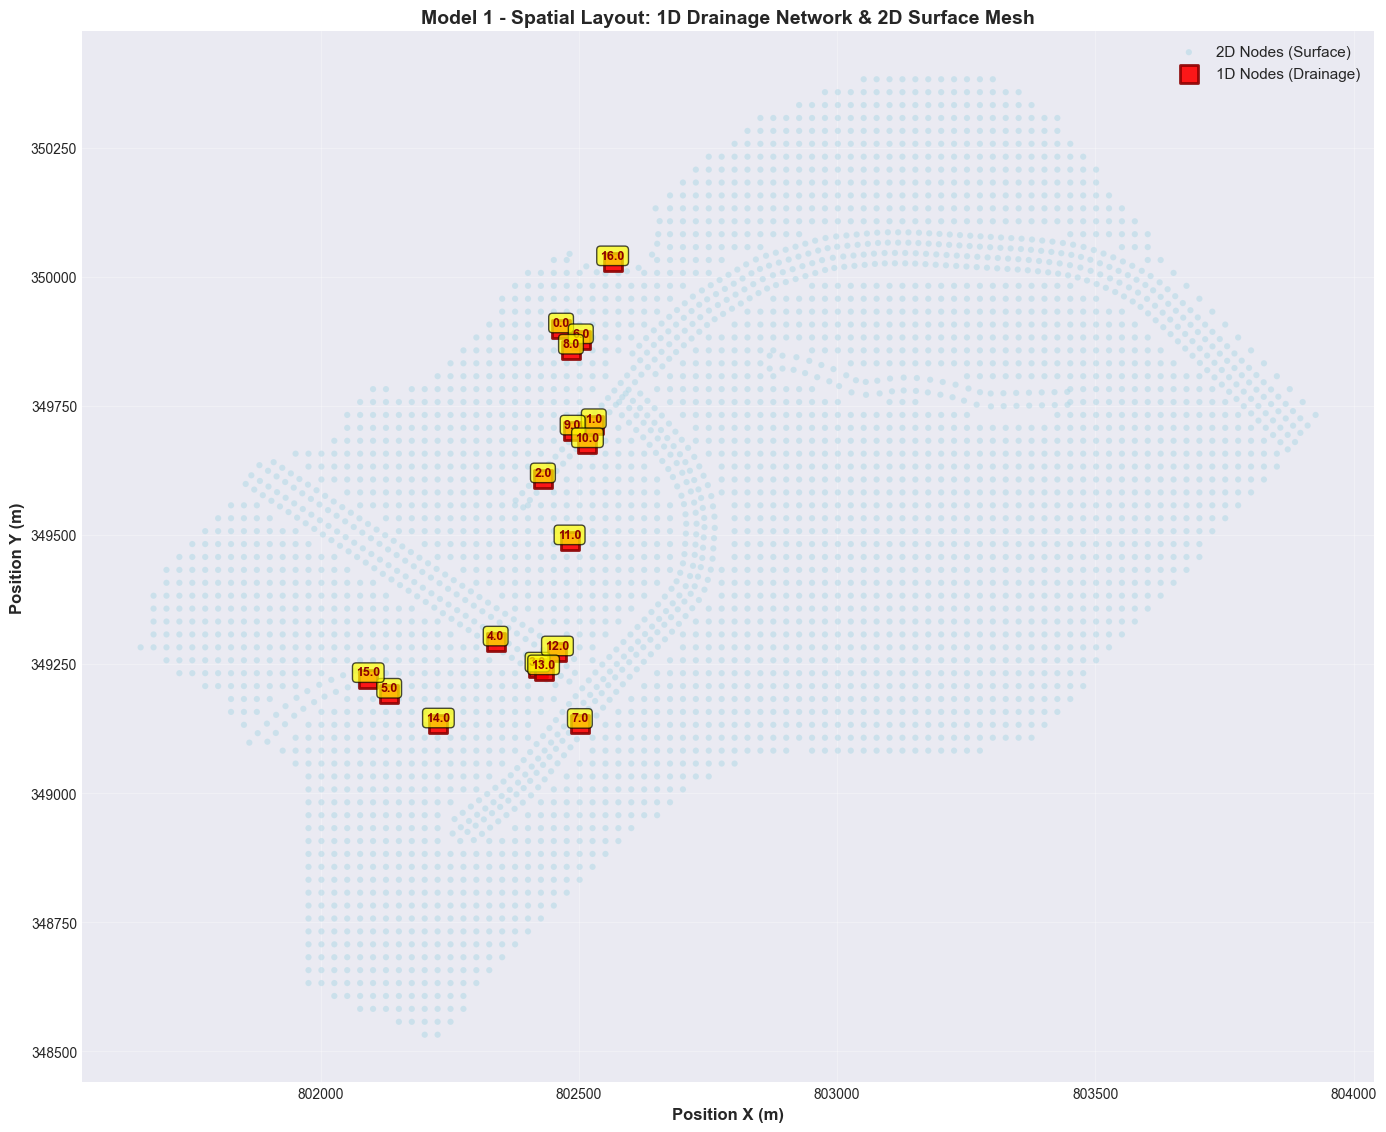


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\spatial_layout_all_nodes.png

Spatial Statistics:
  X range: 801651.6 - 803926.6 m
  Y range: 348532.4 - 350382.4 m
  Coverage area: ~4.21 km²


In [4]:
print("=" * 80)
print("SPATIAL LAYOUT - ALL NODES")
print("=" * 80)

fig, ax = plt.subplots(figsize=(14, 12))

# Plot 2D nodes (background, smaller)
ax.scatter(nodes_2d['position_x'], nodes_2d['position_y'], 
           c='lightblue', s=20, alpha=0.5, label='2D Nodes (Surface)', edgecolors='none')

# Plot 1D nodes (foreground, larger)
ax.scatter(nodes_1d['position_x'], nodes_1d['position_y'], 
           c='red', s=150, alpha=0.9, label='1D Nodes (Drainage)', 
           edgecolors='darkred', linewidth=2, marker='s')

# Label 1D nodes
for idx, row in nodes_1d.iterrows():
    ax.annotate(f"{row['node_idx']}", 
                (row['position_x'], row['position_y']),
                fontsize=9, fontweight='bold', color='darkred',
                ha='center', va='bottom', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Position X (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Position Y (m)', fontsize=12, fontweight='bold')
ax.set_title('Model 1 - Spatial Layout: 1D Drainage Network & 2D Surface Mesh', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'spatial_layout_all_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'spatial_layout_all_nodes.png'}")
print(f"\nSpatial Statistics:")
print(f"  X range: {nodes_2d['position_x'].min():.1f} - {nodes_2d['position_x'].max():.1f} m")
print(f"  Y range: {nodes_2d['position_y'].min():.1f} - {nodes_2d['position_y'].max():.1f} m")
print(f"  Coverage area: ~{(nodes_2d['position_x'].max()-nodes_2d['position_x'].min())*(nodes_2d['position_y'].max()-nodes_2d['position_y'].min())/1e6:.2f} km²")

## 4. Elevation Heatmap with 1D Overlay

ELEVATION HEATMAP - 2D MESH WITH 1D OVERLAY


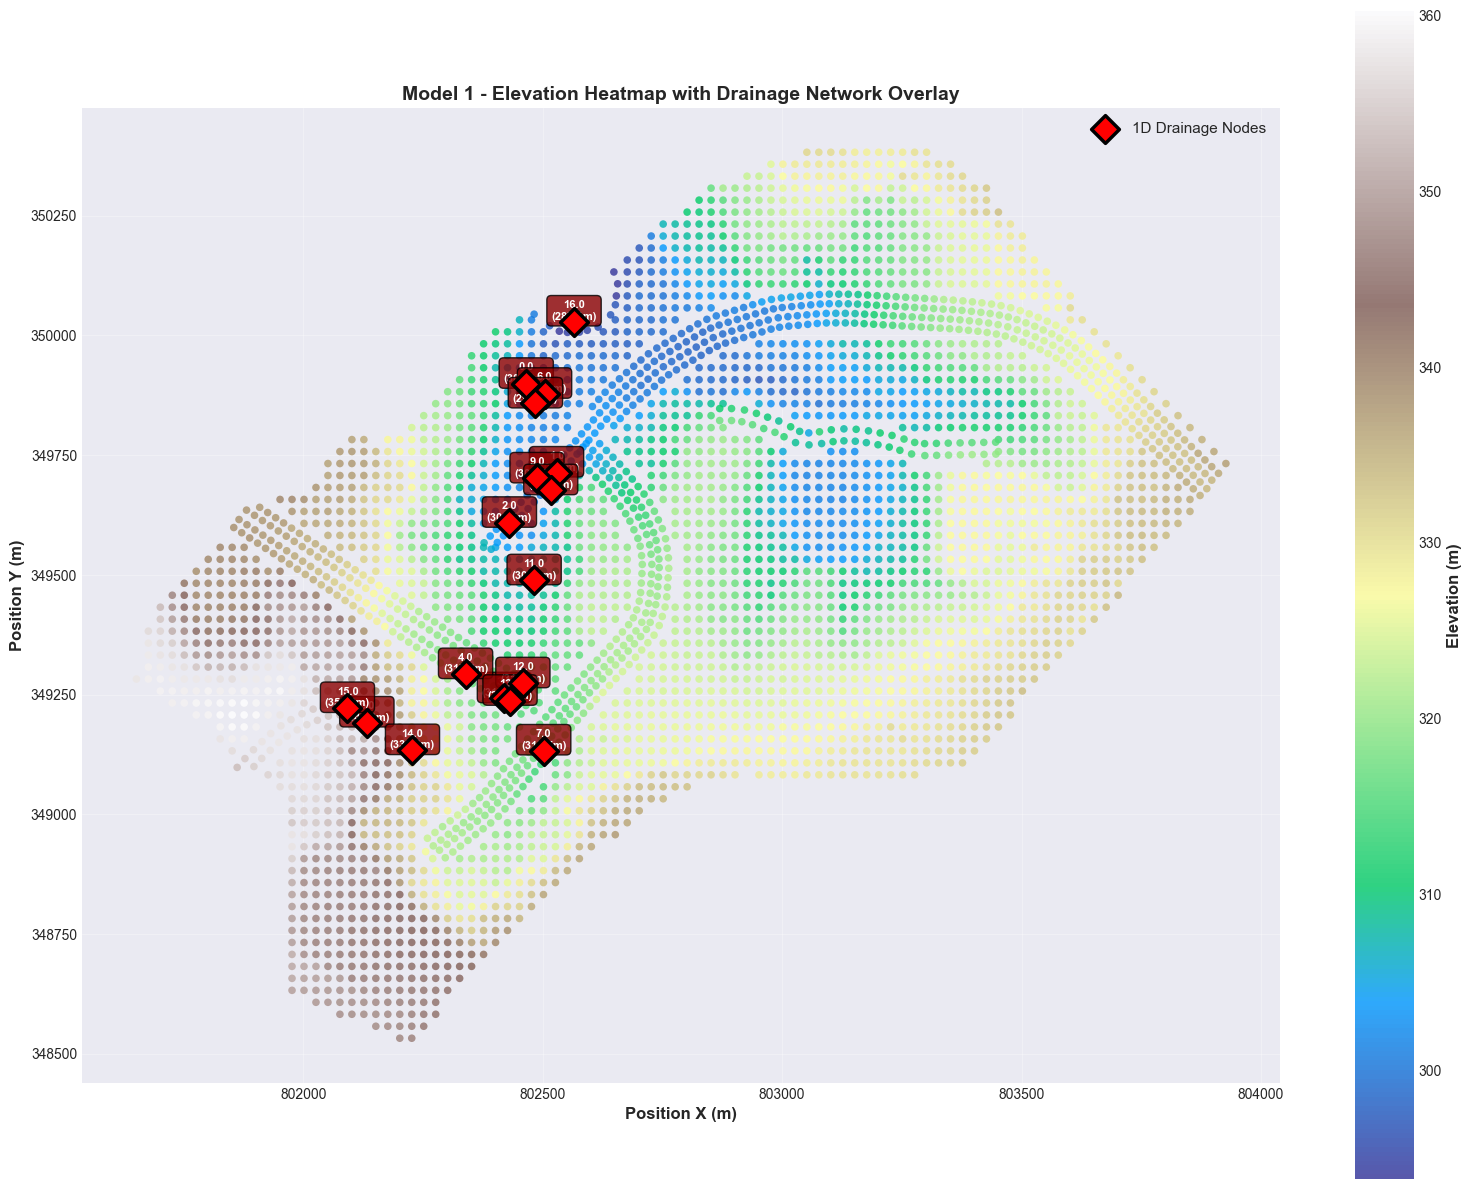


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\elevation_heatmap_with_1d_overlay.png

Elevation Statistics:
  2D Mesh elevation range: 293.81 - 360.22 m
  1D Surface elevation range: 287.07 - 350.85 m
  1D Invert elevation range: 286.60 - 348.43 m


In [5]:
print("=" * 80)
print("ELEVATION HEATMAP - 2D MESH WITH 1D OVERLAY")
print("=" * 80)

fig, ax = plt.subplots(figsize=(16, 12))

# Create elevation scatter plot (using elevation as color)
scatter = ax.scatter(nodes_2d['position_x'], nodes_2d['position_y'], 
                     c=nodes_2d['elevation'], s=30, alpha=0.8, 
                     cmap='terrain', edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Elevation (m)', fontsize=12, fontweight='bold')

# Overlay 1D nodes
ax.scatter(nodes_1d['position_x'], nodes_1d['position_y'], 
           c='red', s=200, alpha=1.0, 
           edgecolors='black', linewidth=2.5, marker='D',
           label='1D Drainage Nodes', zorder=10)

# Label 1D nodes with their surface elevation
for idx, row in nodes_1d.iterrows():
    ax.annotate(f"{row['node_idx']}\n({row['surface_elevation']:.1f}m)", 
                (row['position_x'], row['position_y']),
                fontsize=8, fontweight='bold', color='white',
                ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='darkred', alpha=0.8, edgecolor='black'))

ax.set_xlabel('Position X (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Position Y (m)', fontsize=12, fontweight='bold')
ax.set_title('Model 1 - Elevation Heatmap with Drainage Network Overlay', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'elevation_heatmap_with_1d_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'elevation_heatmap_with_1d_overlay.png'}")
print(f"\nElevation Statistics:")
print(f"  2D Mesh elevation range: {nodes_2d['elevation'].min():.2f} - {nodes_2d['elevation'].max():.2f} m")
print(f"  1D Surface elevation range: {nodes_1d['surface_elevation'].min():.2f} - {nodes_1d['surface_elevation'].max():.2f} m")
print(f"  1D Invert elevation range: {nodes_1d['invert_elevation'].min():.2f} - {nodes_1d['invert_elevation'].max():.2f} m")

## 5. Distance Analysis - 2D to Nearest 1D Node

In [6]:
print("=" * 80)
print("DISTANCE ANALYSIS - 2D NODES TO NEAREST 1D NODE")
print("=" * 80)

# Get coordinates
coords_1d = nodes_1d[['position_x', 'position_y']].values
coords_2d = nodes_2d[['position_x', 'position_y']].values

# Calculate distance matrix (2D nodes x 1D nodes)
print("\nCalculating distance matrix...")
dist_matrix = distance_matrix(coords_2d, coords_1d)

# Find nearest 1D node for each 2D node
nearest_1d_idx = np.argmin(dist_matrix, axis=1)
nearest_1d_dist = np.min(dist_matrix, axis=1)

# Add to dataframe
nodes_2d['nearest_1d_node'] = nearest_1d_idx
nodes_2d['distance_to_nearest_1d'] = nearest_1d_dist

print(f"\n✓ Distance calculations complete!")
print(f"\nDistance Statistics:")
print(f"  Min distance: {nearest_1d_dist.min():.2f} m")
print(f"  Max distance: {nearest_1d_dist.max():.2f} m")
print(f"  Mean distance: {nearest_1d_dist.mean():.2f} m")
print(f"  Median distance: {np.median(nearest_1d_dist):.2f} m")
print(f"  Std distance: {nearest_1d_dist.std():.2f} m")

DISTANCE ANALYSIS - 2D NODES TO NEAREST 1D NODE

Calculating distance matrix...

✓ Distance calculations complete!

Distance Statistics:
  Min distance: 2.17 m
  Max distance: 1393.07 m
  Mean distance: 454.91 m
  Median distance: 370.33 m
  Std distance: 334.54 m


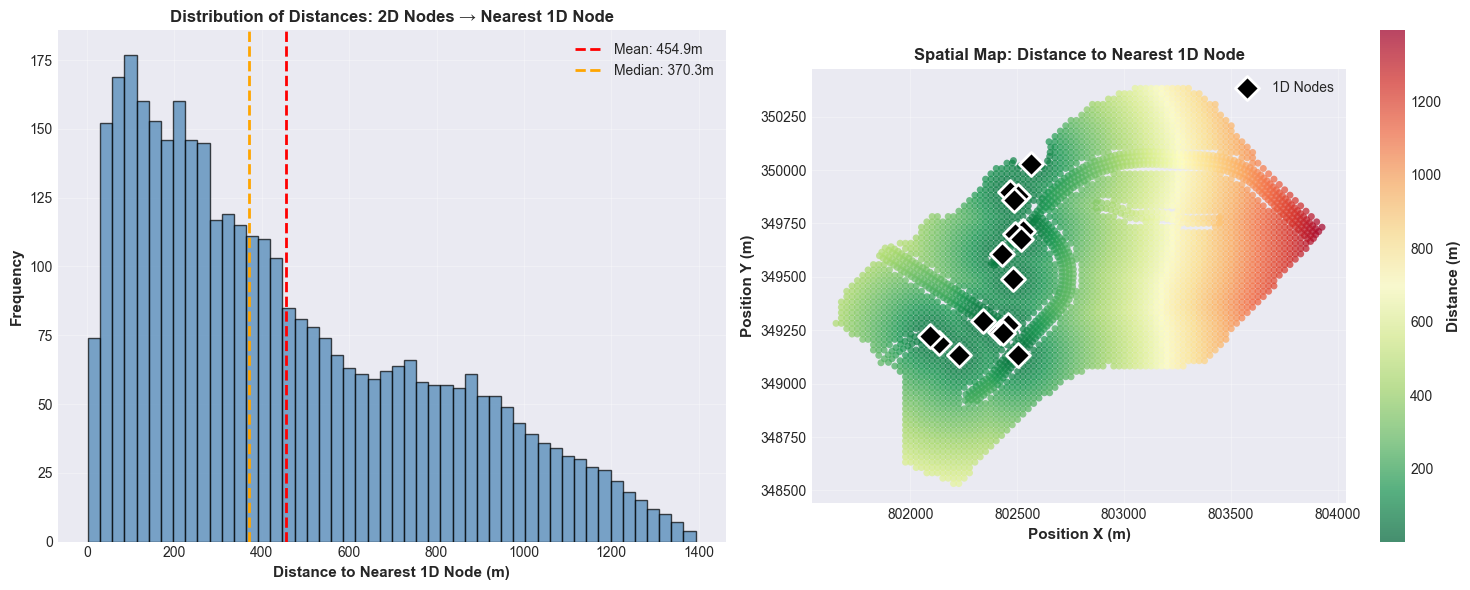


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\distance_analysis_2d_to_1d.png


In [7]:
# Visualize distance distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of distances
axes[0].hist(nearest_1d_dist, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(nearest_1d_dist.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {nearest_1d_dist.mean():.1f}m')
axes[0].axvline(np.median(nearest_1d_dist), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(nearest_1d_dist):.1f}m')
axes[0].set_xlabel('Distance to Nearest 1D Node (m)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Distances: 2D Nodes → Nearest 1D Node', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Spatial map of distances
scatter = axes[1].scatter(nodes_2d['position_x'], nodes_2d['position_y'], 
                          c=nodes_2d['distance_to_nearest_1d'], s=25, 
                          cmap='RdYlGn_r', alpha=0.7, edgecolors='none')
axes[1].scatter(nodes_1d['position_x'], nodes_1d['position_y'], 
                c='black', s=150, marker='D', label='1D Nodes', 
                edgecolors='white', linewidth=2, zorder=10)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Distance (m)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Position X (m)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Position Y (m)', fontsize=11, fontweight='bold')
axes[1].set_title('Spatial Map: Distance to Nearest 1D Node', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'distance_analysis_2d_to_1d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'distance_analysis_2d_to_1d.png'}")

## 6. 1D Network Analysis - Drainage Network

In [8]:
print("=" * 80)
print("1D NETWORK ANALYSIS - DRAINAGE NETWORK TOPOLOGY")
print("=" * 80)

# Create directed graph from edge index
G_1d = nx.DiGraph()

# Add nodes
for idx in nodes_1d['node_idx']:
    G_1d.add_node(idx)

# Add edges (assuming edge_index has 'source' and 'target' or similar columns)
print(f"\nEdge index columns: {list(edge_index_1d.columns)}")

# Detect column names (could be source/target or similar)
col_names = edge_index_1d.columns.tolist()
source_col = col_names[0]  # First column is typically source
target_col = col_names[1]  # Second column is typically target

for _, row in edge_index_1d.iterrows():
    G_1d.add_edge(int(row[source_col]), int(row[target_col]))

print(f"\n✓ 1D Graph constructed:")
print(f"  Nodes: {G_1d.number_of_nodes()}")
print(f"  Edges: {G_1d.number_of_edges()}")
print(f"  Directed: {G_1d.is_directed()}")

# Calculate degree distribution
in_degrees = dict(G_1d.in_degree())
out_degrees = dict(G_1d.out_degree())
total_degrees = {node: in_degrees[node] + out_degrees[node] for node in G_1d.nodes()}

print(f"\nDegree Statistics:")
print(f"  In-degree range: {min(in_degrees.values())} - {max(in_degrees.values())}")
print(f"  Out-degree range: {min(out_degrees.values())} - {max(out_degrees.values())}")
print(f"  Total degree range: {min(total_degrees.values())} - {max(total_degrees.values())}")

# Identify source and sink nodes
source_nodes = [node for node in G_1d.nodes() if in_degrees[node] == 0]
sink_nodes = [node for node in G_1d.nodes() if out_degrees[node] == 0]

print(f"\nNode Classification:")
print(f"  Source nodes (in-degree=0): {source_nodes}")
print(f"  Sink nodes (out-degree=0): {sink_nodes}")

# Check connectivity
is_weakly_connected = nx.is_weakly_connected(G_1d)
is_strongly_connected = nx.is_strongly_connected(G_1d)

print(f"\nConnectivity:")
print(f"  Weakly connected: {is_weakly_connected}")
print(f"  Strongly connected: {is_strongly_connected}")

if is_weakly_connected:
    # Calculate diameter (longest shortest path)
    G_1d_undirected = G_1d.to_undirected()
    diameter = nx.diameter(G_1d_undirected)
    print(f"  Network diameter: {diameter}")

1D NETWORK ANALYSIS - DRAINAGE NETWORK TOPOLOGY

Edge index columns: ['edge_idx', 'from_node', 'to_node']

✓ 1D Graph constructed:
  Nodes: 17
  Edges: 16
  Directed: True

Degree Statistics:
  In-degree range: 0 - 1
  Out-degree range: 0 - 1
  Total degree range: 0 - 2

Node Classification:
  Source nodes (in-degree=0): [16]
  Sink nodes (out-degree=0): [16]

Connectivity:
  Weakly connected: False
  Strongly connected: False


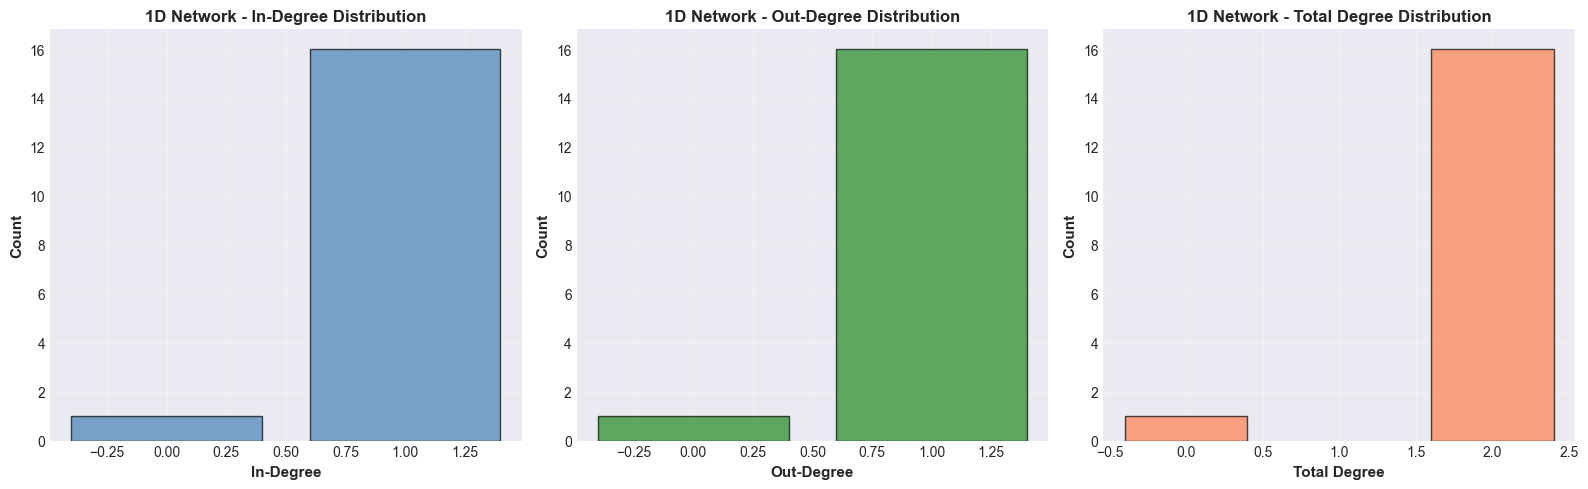


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\1d_network_degree_distribution.png


In [9]:
# Visualize degree distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# In-degree distribution
in_deg_counts = Counter(in_degrees.values())
axes[0].bar(in_deg_counts.keys(), in_deg_counts.values(), alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('In-Degree', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('1D Network - In-Degree Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Out-degree distribution
out_deg_counts = Counter(out_degrees.values())
axes[1].bar(out_deg_counts.keys(), out_deg_counts.values(), alpha=0.7, color='forestgreen', edgecolor='black')
axes[1].set_xlabel('Out-Degree', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('1D Network - Out-Degree Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Total degree distribution
total_deg_counts = Counter(total_degrees.values())
axes[2].bar(total_deg_counts.keys(), total_deg_counts.values(), alpha=0.7, color='coral', edgecolor='black')
axes[2].set_xlabel('Total Degree', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[2].set_title('1D Network - Total Degree Distribution', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '1d_network_degree_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / '1d_network_degree_distribution.png'}")

## 7. Visualize 1D Network as Graph

1D NETWORK VISUALIZATION


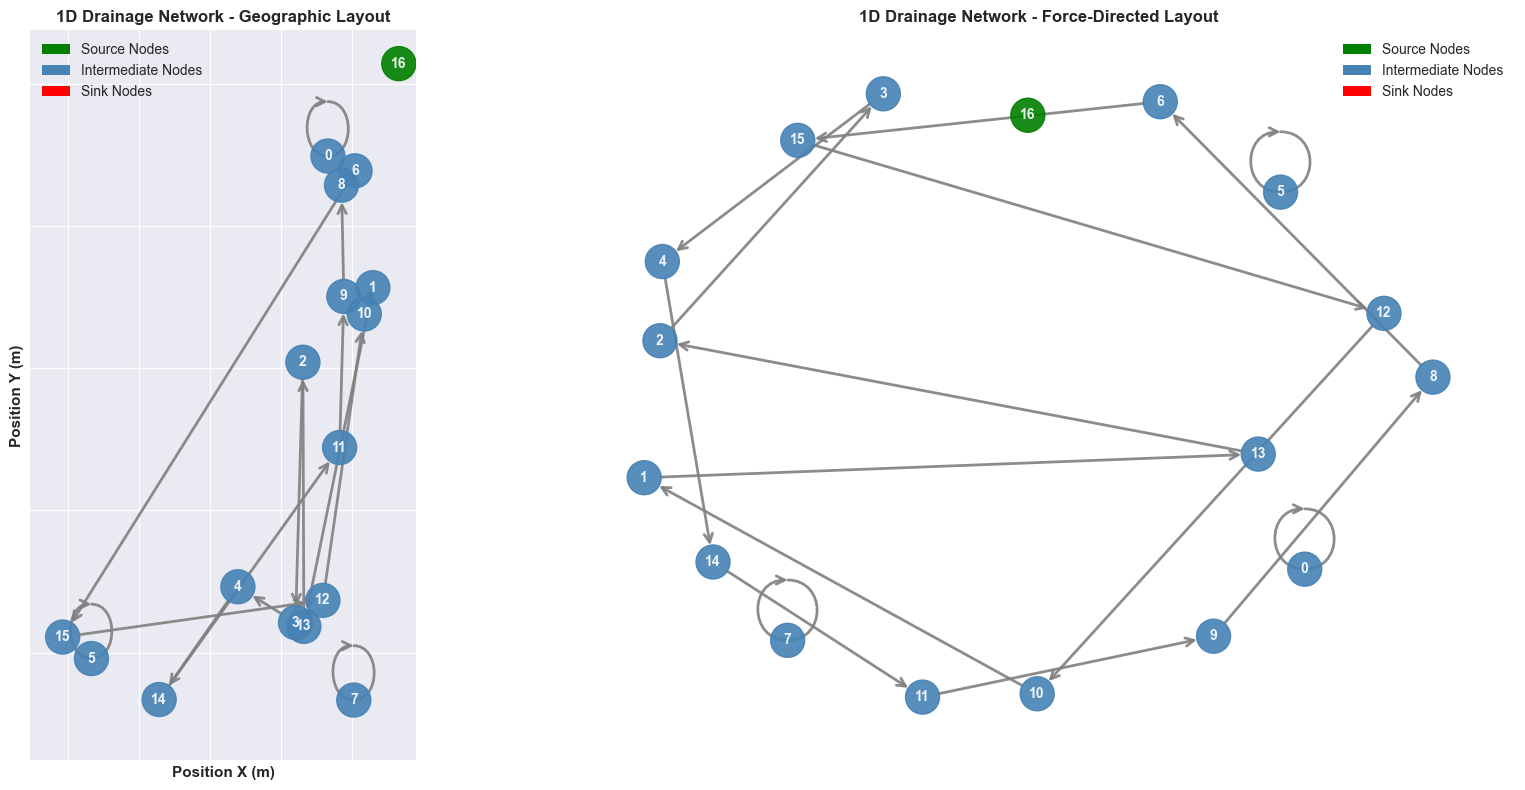


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\1d_network_graph_visualization.png


In [10]:
print("=" * 80)
print("1D NETWORK VISUALIZATION")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Geographic layout
pos_geo = {row['node_idx']: (row['position_x'], row['position_y']) 
           for _, row in nodes_1d.iterrows()}

# Node colors based on type
node_colors = []
for node in G_1d.nodes():
    if node in source_nodes:
        node_colors.append('green')
    elif node in sink_nodes:
        node_colors.append('red')
    else:
        node_colors.append('steelblue')

nx.draw_networkx(G_1d, pos_geo, ax=axes[0],
                 node_color=node_colors, node_size=600,
                 with_labels=True, font_size=10, font_weight='bold',
                 font_color='white', edge_color='gray', 
                 arrows=True, arrowsize=15, arrowstyle='->', 
                 width=2, alpha=0.9)

axes[0].set_xlabel('Position X (m)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Position Y (m)', fontsize=11, fontweight='bold')
axes[0].set_title('1D Drainage Network - Geographic Layout', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal', adjustable='box')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Source Nodes'),
    Patch(facecolor='steelblue', label='Intermediate Nodes'),
    Patch(facecolor='red', label='Sink Nodes')
]
axes[0].legend(handles=legend_elements, loc='best', fontsize=10)

# Right plot: Force-directed layout
pos_spring = nx.spring_layout(G_1d, k=2, iterations=50)

nx.draw_networkx(G_1d, pos_spring, ax=axes[1],
                 node_color=node_colors, node_size=600,
                 with_labels=True, font_size=10, font_weight='bold',
                 font_color='white', edge_color='gray',
                 arrows=True, arrowsize=15, arrowstyle='->',
                 width=2, alpha=0.9)

axes[1].set_title('1D Drainage Network - Force-Directed Layout', fontsize=12, fontweight='bold')
axes[1].legend(handles=legend_elements, loc='best', fontsize=10)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '1d_network_graph_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / '1d_network_graph_visualization.png'}")

## 8. 2D Mesh Network Analysis

In [11]:
print("=" * 80)
print("2D MESH NETWORK ANALYSIS")
print("=" * 80)

# Create undirected graph for 2D mesh
G_2d = nx.Graph()

# Add nodes
for idx in nodes_2d['node_idx']:
    G_2d.add_node(idx)

# Add edges
col_names_2d = edge_index_2d.columns.tolist()
source_col_2d = col_names_2d[0]
target_col_2d = col_names_2d[1]

for _, row in edge_index_2d.iterrows():
    G_2d.add_edge(int(row[source_col_2d]), int(row[target_col_2d]))

print(f"\n✓ 2D Graph constructed:")
print(f"  Nodes: {G_2d.number_of_nodes()}")
print(f"  Edges: {G_2d.number_of_edges()}")
print(f"  Directed: {G_2d.is_directed()}")

# Calculate degree distribution
degrees_2d = dict(G_2d.degree())

print(f"\nDegree Statistics:")
print(f"  Min degree: {min(degrees_2d.values())}")
print(f"  Max degree: {max(degrees_2d.values())}")
print(f"  Mean degree: {np.mean(list(degrees_2d.values())):.2f}")
print(f"  Median degree: {np.median(list(degrees_2d.values())):.1f}")

# Check connectivity
is_connected_2d = nx.is_connected(G_2d)
num_components = nx.number_connected_components(G_2d)

print(f"\nConnectivity:")
print(f"  Fully connected: {is_connected_2d}")
print(f"  Number of components: {num_components}")

if is_connected_2d:
    diameter_2d = nx.diameter(G_2d)
    print(f"  Network diameter: {diameter_2d}")

2D MESH NETWORK ANALYSIS

✓ 2D Graph constructed:
  Nodes: 7935
  Edges: 7935
  Directed: False

Degree Statistics:
  Min degree: 1
  Max degree: 8
  Mean degree: 2.00
  Median degree: 1.0

Connectivity:
  Fully connected: True
  Number of components: 1
  Network diameter: 38


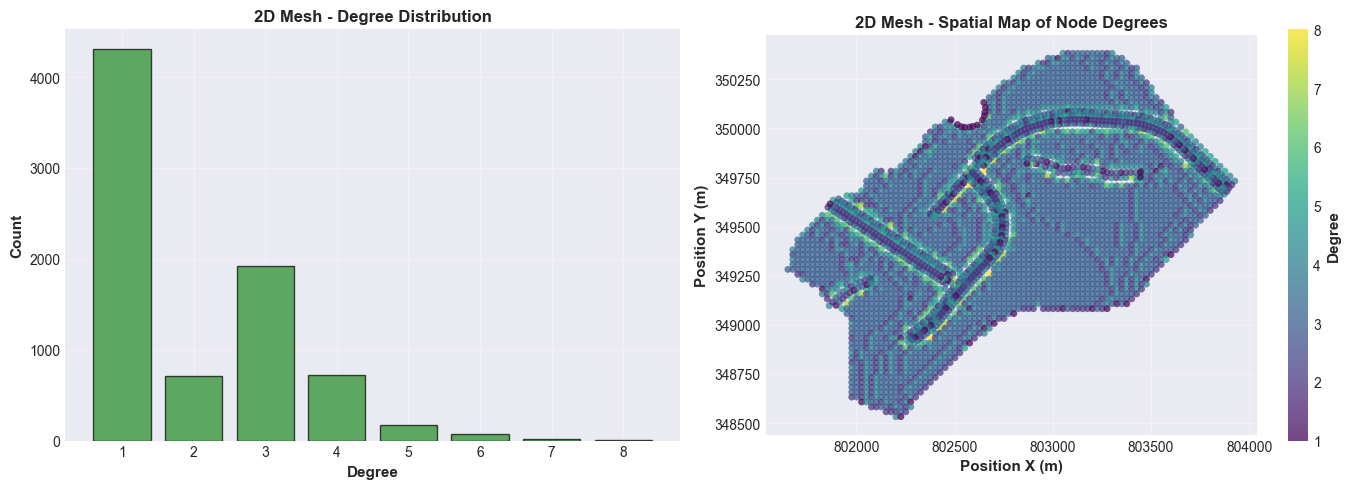


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\2d_mesh_degree_analysis.png

Key Observation: Degree distribution indicates mesh structure
  Typical mesh node: 1 connections
  Expected for regular grid: 4-8 connections
  Boundary/edge nodes: Lower degree (1 connections)


In [12]:
# Visualize 2D degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Degree distribution histogram
degree_counts_2d = Counter(degrees_2d.values())
axes[0].bar(degree_counts_2d.keys(), degree_counts_2d.values(), alpha=0.7, color='forestgreen', edgecolor='black')
axes[0].set_xlabel('Degree', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('2D Mesh - Degree Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Spatial map of degrees
degree_values = [degrees_2d[idx] for idx in nodes_2d['node_idx']]
scatter = axes[1].scatter(nodes_2d['position_x'], nodes_2d['position_y'],
                          c=degree_values, s=25, cmap='viridis', alpha=0.7, edgecolors='none')
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Degree', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Position X (m)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Position Y (m)', fontsize=11, fontweight='bold')
axes[1].set_title('2D Mesh - Spatial Map of Node Degrees', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '2d_mesh_degree_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / '2d_mesh_degree_analysis.png'}")
print(f"\nKey Observation: Degree distribution indicates mesh structure")
print(f"  Typical mesh node: {int(np.median(list(degrees_2d.values())))} connections")
print(f"  Expected for regular grid: 4-8 connections")
print(f"  Boundary/edge nodes: Lower degree ({min(degrees_2d.values())} connections)")

## 9. 1D-2D Coupling Analysis

In [13]:
print("=" * 80)
print("1D-2D COUPLING ANALYSIS")
print("=" * 80)

print(f"\nConnection data preview:")
print(connections_1d2d.head(10))

# Assuming connections have columns like '1d_node' and '2d_node' or similar
conn_cols = connections_1d2d.columns.tolist()
print(f"\nConnection columns: {conn_cols}")

# Identify the column names
col_1d = conn_cols[0]  # Typically first column is 1D node
col_2d = conn_cols[1]  # Typically second column is 2D node

# Count connections per 1D node
connections_per_1d = connections_1d2d.groupby(col_1d).size().reset_index(name='num_connections')

print(f"\n✓ Coupling statistics:")
print(f"  Total 1D-2D connections: {len(connections_1d2d)}")
print(f"  1D nodes with connections: {connections_1d2d[col_1d].nunique()}")
print(f"  2D nodes with connections: {connections_1d2d[col_2d].nunique()}")

print(f"\nConnections per 1D node:")
print(connections_per_1d.to_string(index=False))

print(f"\nStatistics:")
print(f"  Min connections per 1D node: {connections_per_1d['num_connections'].min()}")
print(f"  Max connections per 1D node: {connections_per_1d['num_connections'].max()}")
print(f"  Mean connections per 1D node: {connections_per_1d['num_connections'].mean():.2f}")

1D-2D COUPLING ANALYSIS

Connection data preview:
   connection_idx  node_1d  node_2d
0               0        0      503
1               1       13     3669
2               2       12     3588
3               3        3     3595
4               4        4     3600
5               5       14     2378
6               6        5     2262
7               7       15     2152
8               8        7     3241
9               9        6      551

Connection columns: ['connection_idx', 'node_1d', 'node_2d']

✓ Coupling statistics:
  Total 1D-2D connections: 16
  1D nodes with connections: 16
  2D nodes with connections: 16

Connections per 1D node:
 connection_idx  num_connections
              0                1
              1                1
              2                1
              3                1
              4                1
              5                1
              6                1
              7                1
              8                1
              9   

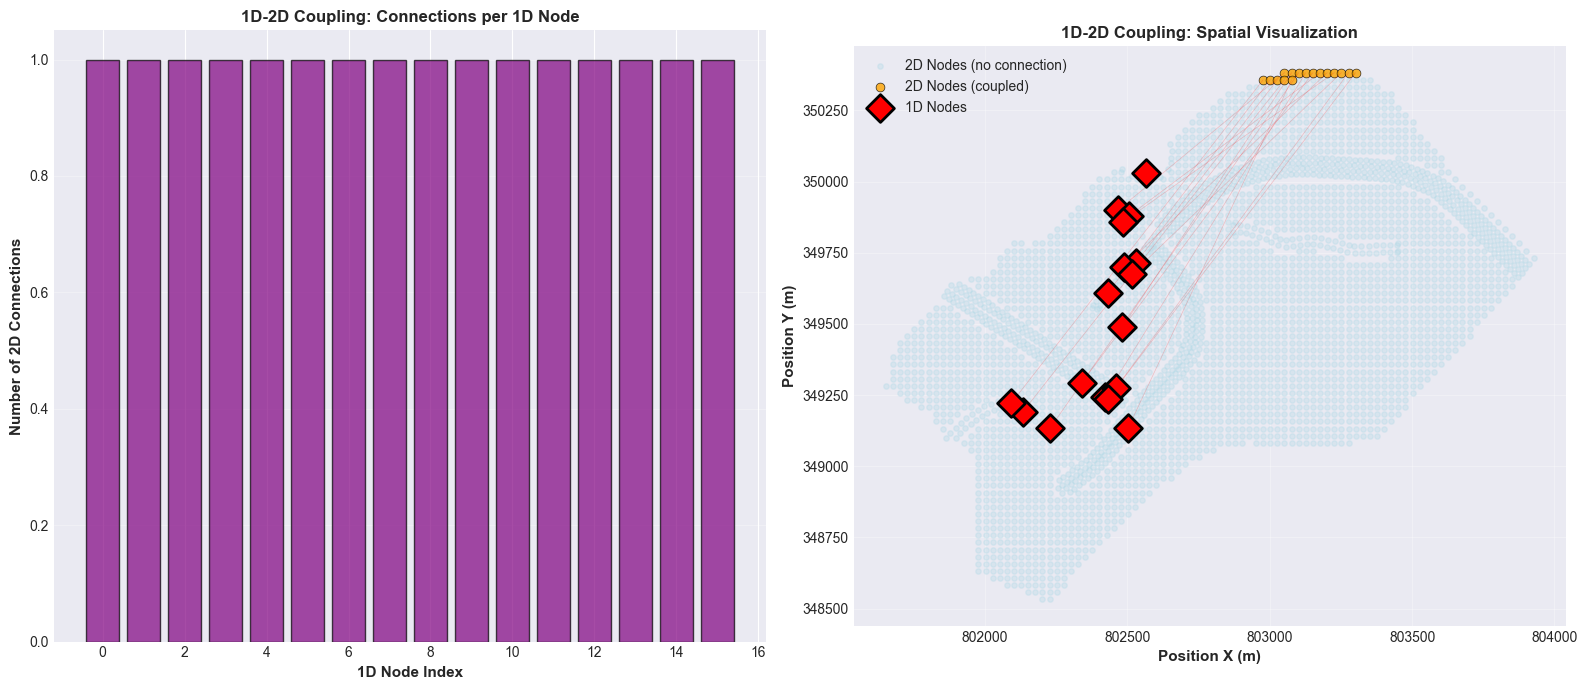


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\1d_2d_coupling_analysis.png


In [14]:
# Visualize coupling connections
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Bar chart: Connections per 1D node
axes[0].bar(connections_per_1d[col_1d], connections_per_1d['num_connections'], 
            alpha=0.7, color='purple', edgecolor='black')
axes[0].set_xlabel('1D Node Index', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of 2D Connections', fontsize=11, fontweight='bold')
axes[0].set_title('1D-2D Coupling: Connections per 1D Node', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Spatial visualization of coupling
axes[1].scatter(nodes_2d['position_x'], nodes_2d['position_y'], 
                c='lightblue', s=15, alpha=0.3, label='2D Nodes (no connection)')

# Highlight connected 2D nodes
connected_2d_indices = connections_1d2d[col_2d].unique()
connected_2d_nodes = nodes_2d[nodes_2d['node_idx'].isin(connected_2d_indices)]
axes[1].scatter(connected_2d_nodes['position_x'], connected_2d_nodes['position_y'],
                c='orange', s=40, alpha=0.8, label='2D Nodes (coupled)', edgecolors='black', linewidth=0.5)

# Plot 1D nodes and their coupling zones
for _, row in nodes_1d.iterrows():
    node_id = row['node_idx']
    # Get connected 2D nodes for this 1D node
    connected_2d_for_this_1d = connections_1d2d[connections_1d2d[col_1d] == node_id][col_2d].values
    connected_coords = nodes_2d[nodes_2d['node_idx'].isin(connected_2d_for_this_1d)]
    
    # Draw lines from 1D to connected 2D nodes
    for _, coord_row in connected_coords.iterrows():
        axes[1].plot([row['position_x'], coord_row['position_x']],
                     [row['position_y'], coord_row['position_y']],
                     'r-', alpha=0.2, linewidth=0.5)

# Overlay 1D nodes
axes[1].scatter(nodes_1d['position_x'], nodes_1d['position_y'],
                c='red', s=200, marker='D', label='1D Nodes',
                edgecolors='black', linewidth=2, zorder=10)

# Label 1D nodes
for _, row in nodes_1d.iterrows():
    axes[1].annotate(f"{row['node_idx']}", 
                     (row['position_x'], row['position_y']),
                     fontsize=9, fontweight='bold', color='white',
                     ha='center', va='center')

axes[1].set_xlabel('Position X (m)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Position Y (m)', fontsize=11, fontweight='bold')
axes[1].set_title('1D-2D Coupling: Spatial Visualization', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '1d_2d_coupling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / '1d_2d_coupling_analysis.png'}")

## 10. Summary & Key Findings

In [15]:
print("=" * 80)
print("KEY FINDINGS - SPATIAL & NETWORK TOPOLOGY ANALYSIS")
print("=" * 80)

findings = f"""
SPATIAL CHARACTERISTICS:

Coverage Area:
  • X extent: {nodes_2d['position_x'].min():.1f} - {nodes_2d['position_x'].max():.1f} m
  • Y extent: {nodes_2d['position_y'].min():.1f} - {nodes_2d['position_y'].max():.1f} m
  • Total area: ~{(nodes_2d['position_x'].max()-nodes_2d['position_x'].min())*(nodes_2d['position_y'].max()-nodes_2d['position_y'].min())/1e6:.2f} km²

Elevation:
  • 2D surface range: {nodes_2d['elevation'].min():.2f} - {nodes_2d['elevation'].max():.2f} m
  • 1D surface range: {nodes_1d['surface_elevation'].min():.2f} - {nodes_1d['surface_elevation'].max():.2f} m
  • 1D invert range: {nodes_1d['invert_elevation'].min():.2f} - {nodes_1d['invert_elevation'].max():.2f} m

Distance to Drainage:
  • Min distance 2D→1D: {nearest_1d_dist.min():.2f} m
  • Max distance 2D→1D: {nearest_1d_dist.max():.2f} m
  • Mean distance 2D→1D: {nearest_1d_dist.mean():.2f} m

1D DRAINAGE NETWORK TOPOLOGY:

Network Structure:
  • Nodes: {G_1d.number_of_nodes()}
  • Edges: {G_1d.number_of_edges()}
  • Type: Directed graph (flow direction matters)
  • Connectivity: {"Fully connected (weak)" if is_weakly_connected else "Disconnected components"}

Node Classification:
  • Source nodes (upstream): {len(source_nodes)} nodes {source_nodes}
  • Sink nodes (downstream): {len(sink_nodes)} nodes {sink_nodes}
  • Intermediate nodes: {G_1d.number_of_nodes() - len(source_nodes) - len(sink_nodes)}

Degree Statistics:
  • In-degree range: {min(in_degrees.values())} - {max(in_degrees.values())}
  • Out-degree range: {min(out_degrees.values())} - {max(out_degrees.values())}
  • Network diameter: {diameter if is_weakly_connected else "N/A (disconnected)"}

2D SURFACE MESH TOPOLOGY:

Network Structure:
  • Nodes: {G_2d.number_of_nodes()}
  • Edges: {G_2d.number_of_edges()}
  • Type: Undirected graph (symmetric connectivity)
  • Connectivity: {"Fully connected" if is_connected_2d else f"Disconnected ({num_components} components)"}

Degree Statistics:
  • Min degree: {min(degrees_2d.values())}
  • Max degree: {max(degrees_2d.values())}
  • Mean degree: {np.mean(list(degrees_2d.values())):.2f}
  • Median degree: {np.median(list(degrees_2d.values())):.1f}
  • Mesh structure: {"Regular grid-like" if 4 <= np.median(list(degrees_2d.values())) <= 8 else "Irregular"}

1D-2D COUPLING:

Connection Statistics:
  • Total coupling connections: {len(connections_1d2d)}
  • 1D nodes with connections: {connections_1d2d[col_1d].nunique()} / {len(nodes_1d)}
  • 2D nodes with connections: {connections_1d2d[col_2d].nunique()} / {len(nodes_2d)}
  • Connections per 1D node: {connections_per_1d['num_connections'].min()} - {connections_per_1d['num_connections'].max()}
  • Mean connections per 1D: {connections_per_1d['num_connections'].mean():.2f}

OUTPUTS GENERATED:
  • {FIGURES_DIR / 'spatial_layout_all_nodes.png'}
  • {FIGURES_DIR / 'elevation_heatmap_with_1d_overlay.png'}
  • {FIGURES_DIR / 'distance_analysis_2d_to_1d.png'}
  • {FIGURES_DIR / '1d_network_degree_distribution.png'}
  • {FIGURES_DIR / '1d_network_graph_visualization.png'}
  • {FIGURES_DIR / '2d_mesh_degree_analysis.png'}
  • {FIGURES_DIR / '1d_2d_coupling_analysis.png'}

MODELING IMPLICATIONS:
  1. Small 1D network → Can use full graph convolutions without subsampling
  2. Large 2D mesh → May need batching or hierarchical approaches
  3. Sparse coupling → 1D-2D message passing is localized
  4. Connected networks → Graph neural networks can propagate information effectively
  5. Degree variation → Edge features may be important for normalization
  6. Directional 1D flow → GNN should respect flow direction (directed edges)
  7. Proximity to drainage → Distance features could improve predictions
"""

print(findings)

# Save summary report
with open(OUTPUT_DIR / 'part3_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("URBAN FLOOD FORECASTING - PART 3 ANALYSIS SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    f.write(findings)

# Save network statistics to CSV
network_stats = pd.DataFrame({
    'Network': ['1D Drainage', '2D Surface Mesh'],
    'Nodes': [G_1d.number_of_nodes(), G_2d.number_of_nodes()],
    'Edges': [G_1d.number_of_edges(), G_2d.number_of_edges()],
    'Type': ['Directed', 'Undirected'],
    'Connected': [is_weakly_connected, is_connected_2d],
    'Mean_Degree': [np.mean(list(total_degrees.values())), np.mean(list(degrees_2d.values()))],
    'Diameter': [diameter if is_weakly_connected else None, diameter_2d if is_connected_2d else None]
})
network_stats.to_csv(OUTPUT_DIR / 'network_topology_statistics.csv', index=False)

print("\n" + "=" * 80)
print("✓ PART 3 COMPLETE - SPATIAL & NETWORK TOPOLOGY ANALYSIS")
print("=" * 80)
print(f"\n✓ Summary report saved to: {OUTPUT_DIR / 'part3_summary_report.txt'}")
print(f"✓ Network statistics saved to: {OUTPUT_DIR / 'network_topology_statistics.csv'}")

KEY FINDINGS - SPATIAL & NETWORK TOPOLOGY ANALYSIS

SPATIAL CHARACTERISTICS:

Coverage Area:
  • X extent: 801651.6 - 803926.6 m
  • Y extent: 348532.4 - 350382.4 m
  • Total area: ~4.21 km²

Elevation:
  • 2D surface range: 293.81 - 360.22 m
  • 1D surface range: 287.07 - 350.85 m
  • 1D invert range: 286.60 - 348.43 m

Distance to Drainage:
  • Min distance 2D→1D: 2.17 m
  • Max distance 2D→1D: 1393.07 m
  • Mean distance 2D→1D: 454.91 m

1D DRAINAGE NETWORK TOPOLOGY:

Network Structure:
  • Nodes: 17
  • Edges: 16
  • Type: Directed graph (flow direction matters)
  • Connectivity: Disconnected components

Node Classification:
  • Source nodes (upstream): 1 nodes [16]
  • Sink nodes (downstream): 1 nodes [16]
  • Intermediate nodes: 15

Degree Statistics:
  • In-degree range: 0 - 1
  • Out-degree range: 0 - 1
  • Network diameter: N/A (disconnected)

2D SURFACE MESH TOPOLOGY:

Network Structure:
  • Nodes: 7935
  • Edges: 7935
  • Type: Undirected graph (symmetric connectivity)
  • C